## Phase 1: Data Preparation & Feature Engineering
##### Transform raw individual transactions into a single row per customer with "behavioral features."

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import openpyxl
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
import shap

In [2]:
# 1. Load Data (assuming you have the csv)
df = pd.read_excel("data/online_retail_II.xlsx") 
# For demo purposes, let's assume 'df' is loaded with columns:
['InvoiceNo', 'StockCode', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

['InvoiceNo',
 'StockCode',
 'Quantity',
 'InvoiceDate',
 'UnitPrice',
 'CustomerID',
 'Country']

In [3]:
print(df.columns.tolist())

['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']


In [4]:
# 2. Data Cleaning
df = df.dropna(subset=['Customer ID']) # We need ID to track users
df = df[df['Quantity'] > 0] # Remove returns/cancellations for purchase prediction
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalSum'] = df['Quantity'] * df['Price']

In [5]:
# 3. Create a Snapshot Date
# We pretend today is the day after the last recorded transaction
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

In [6]:
# 4. Feature Engineering: RFM & Behavioral Features
# Group by CustomerID
customer_features = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'Invoice': 'nunique',                                  # Frequency
    'TotalSum': 'sum',                                       # Monetary Value
    'Quantity': 'mean'                                       # Avg Basket Size
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'Monetary',
    'Quantity': 'AvgBasketSize'
})

# Add Tenure (First purchase to now)
customer_tenure = df.groupby('Customer ID').agg({'InvoiceDate': lambda x: (snapshot_date - x.min()).days})
customer_features['Tenure'] = customer_tenure['InvoiceDate']

In [7]:
# 5. Create Targets (Who & When)
# In a real scenario, you split data by time (e.g., Train = Jan-Oct, Test = Nov).
# Here we simulate a target for demonstration:
# Let's assume we want to predict if they buy in the *next* 30 days.
# Since this is a static dataset, we usually hold out the last 30 days for testing.

# Splitting data strictly by time for realistic "Next Month" prediction
holdout_days = 30
cutoff_date = df['InvoiceDate'].max() - dt.timedelta(days=holdout_days)

# Train Data: Behavior BEFORE cutoff
train_df = df[df['InvoiceDate'] <= cutoff_date]
# Target Data: Behavior AFTER cutoff
target_df = df[df['InvoiceDate'] > cutoff_date]

# Re-calculate features on TRAIN data only (to prevent leakage)
X = train_df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (cutoff_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalSum': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'TotalSum': 'Monetary'})

# Create Targets
targets = target_df.groupby('Customer ID').agg({'InvoiceDate': 'min'})
targets['NextPurchaseDay'] = (targets['InvoiceDate'] - cutoff_date).dt.days

# Merge Targets into Features
data = X.merge(targets['NextPurchaseDay'], on='Customer ID', how='left')

# Target 1: Who? (Binary: Did they buy in the holdout period?)
data['WillConvert'] = data['NextPurchaseDay'].notnull().astype(int)

# Target 2: When? (Regression: Days to purchase. Fill non-converters with 999 or cap)
data['DaysToNextPurchase'] = data['NextPurchaseDay'].fillna(999) 

# Fill missing features (customers who didn't buy in train period but existed? 
# In this logic, we only look at existing customers)
data = data.fillna(0)

print(data.head())

             Recency  Frequency  Monetary  NextPurchaseDay  WillConvert  \
Customer ID                                                               
12346.0          134         11    372.86              0.0            0   
12347.0            9          1    611.53             27.0            1   
12348.0           43          1    222.16              0.0            0   
12349.0           12          3   2671.14              0.0            0   
12353.0           13          1    317.76              0.0            0   

             DaysToNextPurchase  
Customer ID                      
12346.0                   999.0  
12347.0                    27.0  
12348.0                   999.0  
12349.0                   999.0  
12353.0                   999.0  


## Phase 2: Modeling (Who & When)
##### We train two models. One to identify the probability of conversion, and another to estimate the timing.

In [8]:
# Prepare Inputs
features = ['Recency', 'Frequency', 'Monetary']
X_model = data[features]
y_who = data['WillConvert']
y_when = data['DaysToNextPurchase']

# Split train/test
X_train, X_test, y_train_who, y_test_who, y_train_when, y_test_when = train_test_split(
    X_model, y_who, y_when, test_size=0.2, random_state=42
)

# --- Model 1: WHO (Classification) ---
clf = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=3)
clf.fit(X_train, y_train_who)
data['Prob_Convert'] = clf.predict_proba(X_model)[:, 1] # Add prediction to main dataframe

# --- Model 2: WHEN (Regression) ---
# We train this only on people who actually converted in history to learn the timing pattern
reg = XGBRegressor(n_estimators=100, learning_rate=0.05)
reg.fit(X_train[y_train_when < 999], y_train_when[y_train_when < 999])
data['Pred_Days_To_Buy'] = reg.predict(X_model)

## Phase 3: Explainability (Why)
##### This step is crucial for marketing. If the model says "User 123 is 90% likely to buy," you need to know why to craft the message.

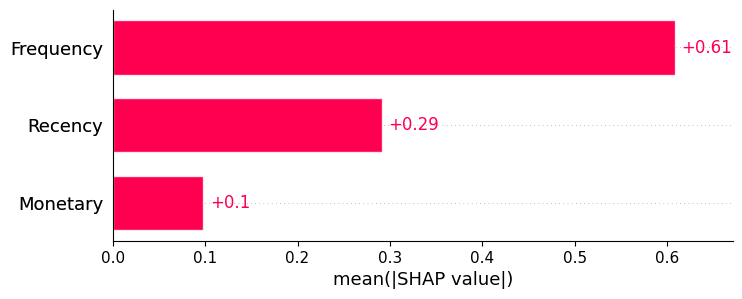

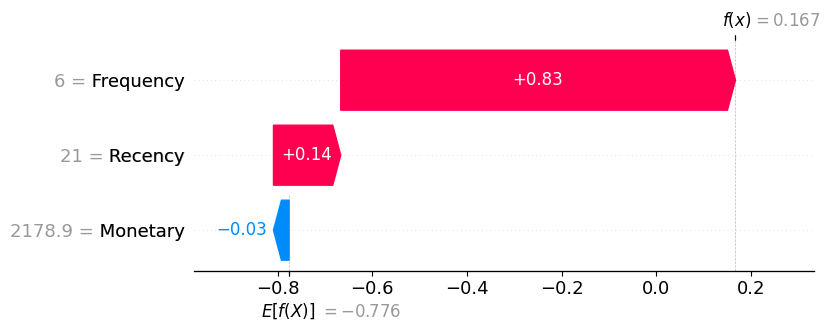

In [9]:
# Initialize SHAP
explainer = shap.Explainer(clf)
shap_values = explainer(X_test)

# Visualize global importance (What drives sales generally?)
shap.plots.bar(shap_values)

# Visualize a single customer (Why is Customer X likely to buy?)
# Logic: If 'Recency' pushes the score up, it means "You haven't bought in a while, you are due."
# Logic: If 'Frequency' pushes score up, it means "You are a loyal habit-buyer."
shap.plots.waterfall(shap_values[0])

#### Business Translation of SHAP:
* High Recency Impact: "Customer is 'cooling down'. Risk of churn." -> Action: Re-engagement campaign.
* High Frequency Impact: "Loyal customer." -> Action: Upsell/VIP offer.

## Phase 4: Automating Marketing Actions
##### Finally, we write the Python logic that acts on these predictions. This function simulates the decision engine of a Marketing Automation platform.

In [10]:
def automated_marketing_action(row):
    """
    Decides the marketing action based on:
    - Probability to Convert (Who)
    - Predicted Days to Buy (When)
    - Monetary Value (Value)
    """
    prob = row['Prob_Convert']
    days_to_buy = row['Pred_Days_To_Buy']
    value = row['Monetary']
    
    # Segment 1: High Probability, High Value (VIPs ready to buy)
    if prob > 0.8 and value > 2000:
        return "TRIGGER: Send 'VIP Early Access' Catalog. (Expected buy in {:.0f} days)".format(days_to_buy)
    
    # Segment 2: High Probability, Low Value (Regulars)
    elif prob > 0.8:
        return "TRIGGER: Send 'Bundle Discount' to increase basket size."
    
    # Segment 3: Low Probability, High History (At Risk Churn)
    elif prob < 0.3 and value > 2000:
        return "ALERT: High Value Churn Risk! Trigger Personal Outreach/Phone Call."
    
    # Segment 4: Ready to buy soon (Timing optimization)
    elif prob > 0.5 and days_to_buy < 7:
        return "TRIGGER: Send 'Free Shipping for 48 Hours' urgency nudge."
    
    else:
        return "ACTION: Add to General Newsletter (Nurture)."

# Apply the automation logic
data['Next_Best_Action'] = data.apply(automated_marketing_action, axis=1)

# View Results
print(data[['Prob_Convert', 'Pred_Days_To_Buy', 'Next_Best_Action']].head())

             Prob_Convert  Pred_Days_To_Buy  \
Customer ID                                   
12346.0          0.143027         14.864328   
12347.0          0.297143         16.969231   
12348.0          0.184330          6.887550   
12349.0          0.284635         13.862354   
12353.0          0.263073         10.950653   

                                              Next_Best_Action  
Customer ID                                                     
12346.0           ACTION: Add to General Newsletter (Nurture).  
12347.0           ACTION: Add to General Newsletter (Nurture).  
12348.0           ACTION: Add to General Newsletter (Nurture).  
12349.0      ALERT: High Value Churn Risk! Trigger Personal...  
12353.0           ACTION: Add to General Newsletter (Nurture).  


## Summary of Results
* Who: Prob_Convert tells you the likelihood.
* When: Pred_Days_To_Buy gives you the timing window (e.g., "Expected in 5 days").
* Why: SHAP plots (not shown in text output) reveal if they are buying due to habit (Frequency) or recovering from a break (Recency).
* Action: The Next_Best_Action column automatically assigns the strategy.

## Phase 5: Serialize (Save) Your Models
##### Here we save the trained clf (classifier) and reg (regressor) objects. We use joblib for efficient storage.

In [11]:
import joblib

# compress=3 is a sweet spot between speed and size (range is 0-9)
joblib.dump(clf, 'models/churn_classifier.joblib', compress=3)
joblib.dump(reg, 'models/days_regressor.joblib', compress=3)

print("Models saved successfully!")

Models saved successfully!
